# US Geographic plots

* Another question that motivated me to build this dataset is use this data as a metric of the differences across the country. This notebook hightlights the population grouped by their geographic location

In [14]:
import numpy as np
import pandas as pd

%matplotlib inline
import pylab
import geoplotlib
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits import basemap
from pysurvey.plot import setup, legend, icolorbar, density, text
from sklearn import cluster
from pycupid import visualize
from IPython.display import Image

import geoplotlib.core
from scipy.ndimage import gaussian_filter
from geoplotlib.layers import KDELayer, BatchPainter

In [2]:
people = pd.read_csv('/Users/ajmendez/data/okcupid/random_v2.csv')

In [5]:
good = people[(people['lon'].notnull()) & 
              (people['lat'].notnull()) & 
              (people['match'] > 20) &
              (people['lat'] > -80) &
              (people['lat'] <  80) &
              (people['lon'] > -180) &
              (people['lon'] <  180) ]
lon, lat = good['lon'].as_matrix(), good['lat'].as_matrix()
match = good['match'].as_matrix()
normmatch = match / (100.0)
print 'Found {:,d} matches of {:,d} total'.format(len(good), len(people))

# Filter to ratio plots below
high = good[good['match'] > 80]
mid = good[(good['match'] > 60) & (good['match']<80)]
nothigh = good[(good['match'] > 20) & (good['match']<80)]
print 'Found {:,d} high matches and {:,d} mid matches'.format(len(high), len(mid))

Found 301,524 matches of 337,153 total
Found 89,263 high matches and 153,806 mid matches


## Density plots

Before we create interesting plots, lets first look at the distribution of the sample across the states.
These plots should not be used since it is roughly a population plot.
It would be of more interest to show the relative excess or dirth of these values to the population since
that highlights where OKCupid has captured the market.
Additionally, with the correct normalization we can highlight differences in the population of each city.

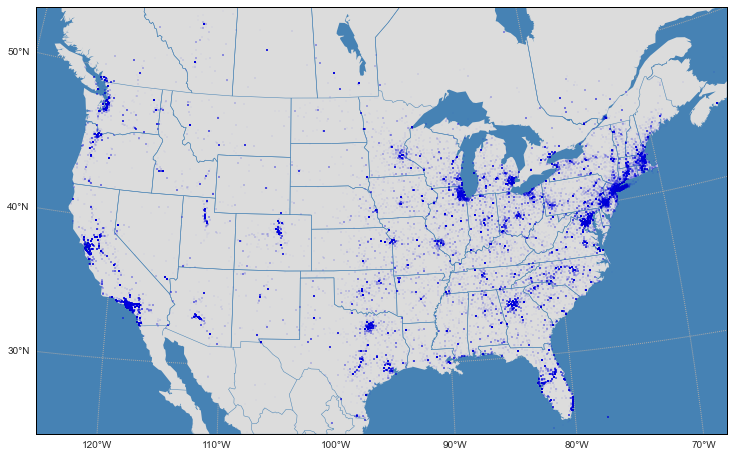

In [7]:
ax = visualize.setup_plot()
x,y = ax.m(lon, lat)
ax.m.scatter(x,y, zorder=2, lw=0, alpha=0.1, s=1)

<matplotlib.colorbar.Colorbar instance at 0x11f2f3e60>

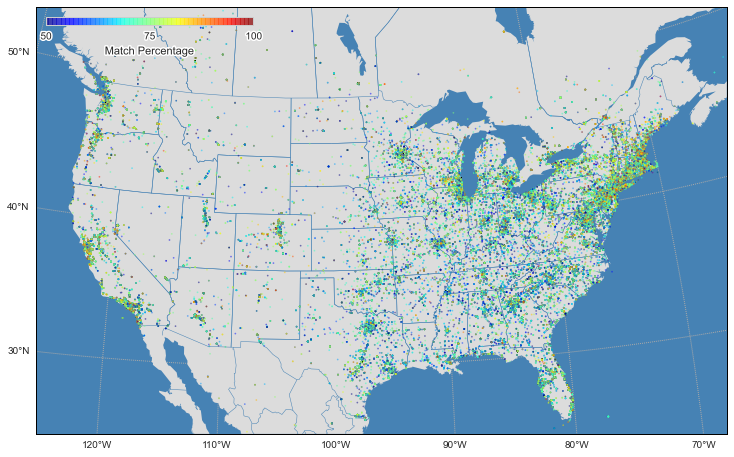

In [8]:
ax = visualize.setup_plot()
x,y = ax.m(lon, lat)
sca = ax.m.scatter(x,y, c=match, label='Match Percentage',
                   vmin=50, vmax=100, cmap=pylab.cm.jet,
                   zorder=2, lw=0, alpha=0.5, s=3)
icolorbar(sca)

<matplotlib.colorbar.Colorbar instance at 0x1210fba70>

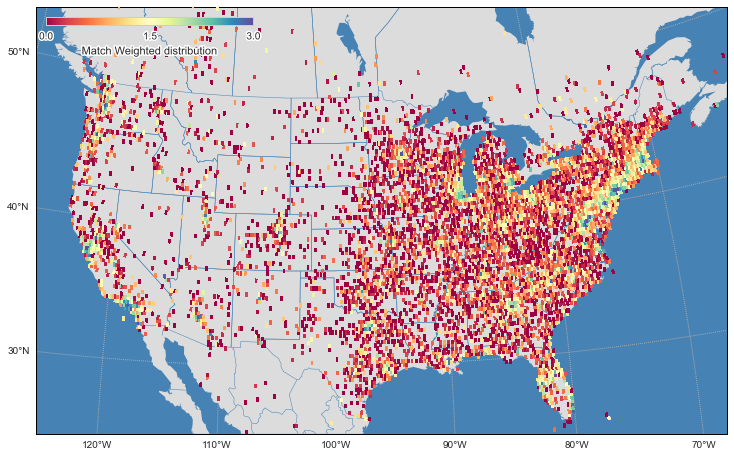

In [9]:
x,y = np.linspace(-150,-50,600), np.linspace(10,60,200)
X,Y = np.meshgrid(x,y)
Z = np.histogram2d(lon, lat, weights=normmatch, bins=(x,y))[0]
Z = np.ma.MaskedArray(np.log10(Z), Z==0)

ax = visualize.setup_plot()
mx, my = ax.m(X,Y)

pcm = ax.m.pcolormesh(mx, my, Z.T, vmin=0, vmax=3,
                      label='Match Weighted distribution',
                      cmap=pylab.cm.Spectral, zorder=10, )
icolorbar(pcm)

In [11]:
geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
geoplotlib.kde(good, 1, alpha=255)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.USA)
geoplotlib.inline(800)

('smallest non-zero count', 1.7910636084771928e-08)
('max count:', 1787.4534574564768)


## Ratios

The previous plots are dominated by the population sampling term.
Through normalizing the population of interest (high match percentage profiles) to the background (moderately matched profiles) we can limit the effect of the population term.

In [12]:
# Sample population across the states in ~0.5deg bins (roughly large cities / counties)
# additionally limit to bins where there are at least 10 samples to limit sampling noise.

x,y = np.linspace(-150,-50,200), np.linspace(10,60,100)
X,Y = np.meshgrid(x,y)
ii = np.where(normmatch > 0.8)
Z = np.histogram2d(lon[ii], lat[ii], bins=(x,y))[0]
Z = np.ma.MaskedArray((Z), Z<10)

ii = np.where((normmatch > 0.6) & (normmatch < 0.8))
Z2 = np.histogram2d(lon[ii], lat[ii], bins=(x,y))[0]
Z2 = np.ma.MaskedArray((Z2), Z2<10)

<matplotlib.colorbar.Colorbar instance at 0x125d27050>

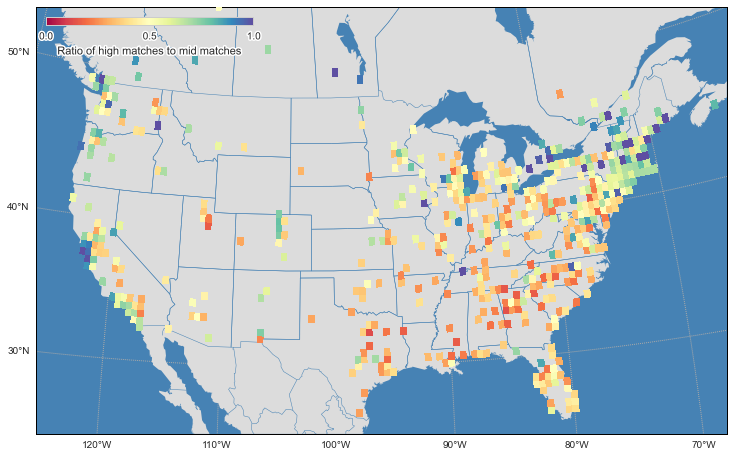

In [15]:
ax = visualize.setup_plot()
mx, my = ax.m(X,Y)

pcm = ax.m.pcolormesh(mx, my, (Z/Z2).T, 
                      vmin=0, vmax=1,
                      label='Ratio of high matches to mid matches',
                      cmap=pylab.cm.Spectral, zorder=10, )
icolorbar(pcm)

While that worked somewhat, 

In [17]:
class KDERatio(KDELayer, object):
    def __init__(self, values, norm, bw, **kwargs):
        super(KDERatio, self).__init__(values, bw, **kwargs)
        self.norm = norm
    
    def invalidate(self, proj):
        self.painter = BatchPainter()
        xv, yv = proj.lonlat_to_screen(self.values['lon'], self.values['lat'])
        xn, yn = proj.lonlat_to_screen(self.norm['lon'], self.norm['lat'])

        rects_vertices = []
        rects_colors = []

        if self.method == 'hist':
            xgrid, ygrid = self._get_grid(proj)
            H = np.histogram2d(yv, xv, bins=(ygrid, xgrid))[0]
            N = np.histogram2d(yn, xn, bins=(ygrid, xgrid))[0]
            
            if H.sum() == 0:
                print('no data in current view')
                return

            H = gaussian_filter(H, sigma=self.bw)
            N = gaussian_filter(N, sigma=self.bw)
#             H = H /(H+N+1.0)
            H = H /(N*0.1)
            H[N <= 10] = 0

            if self.cut_below is None:
                Hmin = H[H > 0][0]
            else:
                Hmin = self.cut_below

            if self.clip_above is None:
                self.Hmax = H.max()
            else:
                self.Hmax = self.clip_above

            if self.scaling == 'ranking':
                from statsmodels.distributions.empirical_distribution import ECDF
                ecdf = ECDF(H.flatten())

            for ix in range(len(xgrid)-2):
                for iy in range(len(ygrid)-2):
                    if H[iy, ix] > Hmin:
                        rects_vertices.append((xgrid[ix], ygrid[iy], xgrid[ix+1], ygrid[iy+1]))
                        if self.scaling == 'ranking':
                            rects_colors.append(self.cmap.to_color(ecdf(H[iy, ix]) - ecdf(Hmin), 1 - ecdf(Hmin), 'lin'))
                        else:
                            rects_colors.append(self.cmap.to_color(H[iy, ix], self.Hmax, self.scaling))
        else:
            raise Exception('method not supported')

        self.painter.batch_rects(rects_vertices, rects_colors)
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        self.painter.batch_draw()
        ui_manager.add_colorbar(self.cmap, self.Hmax, self.scaling)
        

geoplotlib.tiles_provider('darkmatter')
geoplotlib.core.FONT_COLOR = (255,255,255,255)
geoplotlib.set_window_size(800,800)
layer = KDERatio(high, nothigh, 1, cmap=pylab.cm.jet, scaling='lin')
geoplotlib.add_layer(layer)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.USA)
geoplotlib.inline(800)

In [18]:
geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
layer = KDERatio(high, nothigh, 1, cmap=pylab.cm.jet)
geoplotlib.add_layer(layer)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.USA)
geoplotlib.show()

1457458046923.png saved


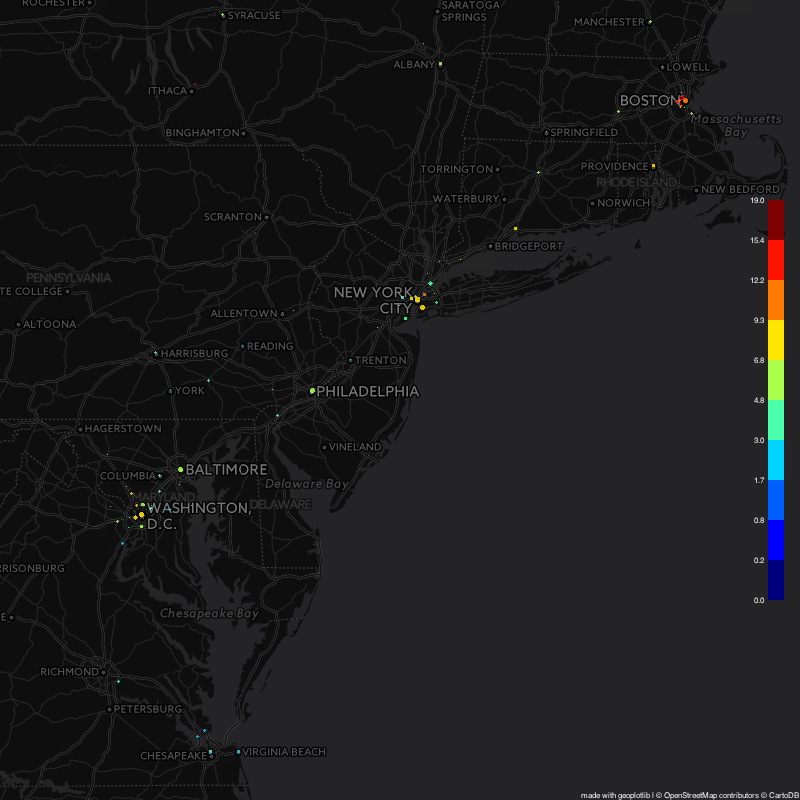

In [14]:
Image('1457422496443.png')

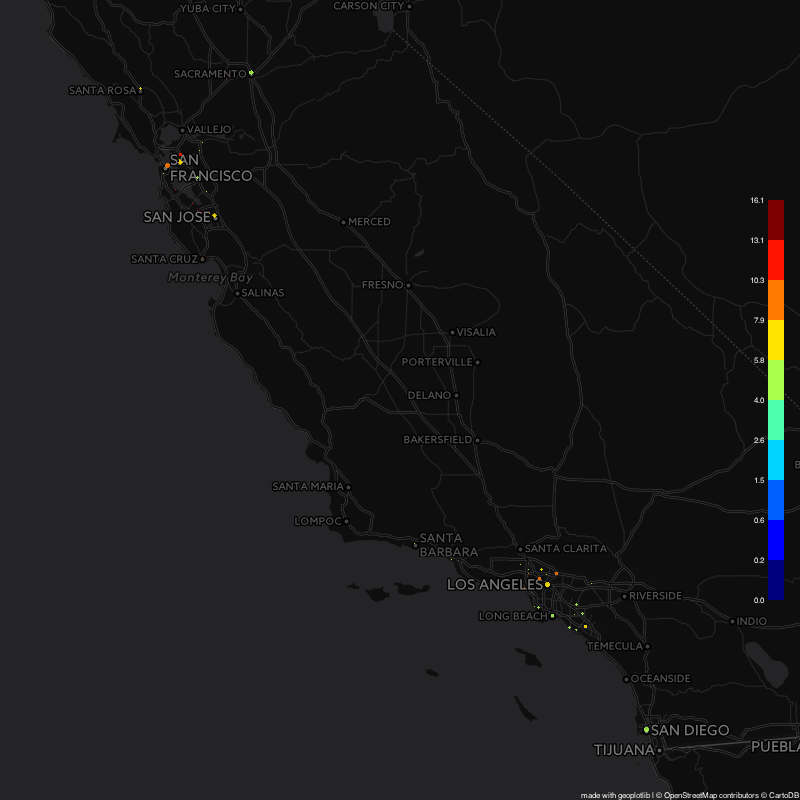

In [19]:
Image('1457458046923.png')

In [20]:
geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
# geoplotlib.kde(high, 0.01*np.ones(len(good)), alpha=255, method='kde')
# geoplotlib.voronoi(high, cmap=pylab.cm.Blues_r, alpha=128)
geoplotlib.voronoi(high, line_width=1, line_color=(0,0,255,40), alpha=128)
# geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.USA)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox(50, -120, 20, -70))
geoplotlib.inline(800)

# Cluster by match

In [15]:
good = people[(people['lon'].notnull()) & 
              (people['lat'].notnull()) & 
              (people['match'] > 20) &
              (people['lat'] >  20) &
              (people['lat'] <  60) &
              (people['lon'] > -150) &
              (people['lon'] <  -70) ]
high = good[good['match'] > 95]
mid = good[(good['match'] > 60) & (good['match']<80)]
nothigh = good[(good['match'] > 20) & (good['match']<80)]
print 'Found {:,d} high matches and {:,d} mid matches'.format(len(high), len(mid))

Found 1,341 high matches and 134,066 mid matches


In [16]:
from sklearn import preprocessing, cluster

In [17]:
# X = norm.fit_transform(high[['lon','lat','match']])
X = preprocessing.scale(high[['lon','lat','match']])
# X = preprocessing.scale(high[['lon','lat']])
# pylab.scatter(X[:,0], X[:,1], c=X[:,2], lw=0, cmap=pylab.cm.Blues)

In [21]:
ms = cluster.MeanShift(bandwidth=0.4)
tmp = ms.fit_predict(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print n_clusters_

57


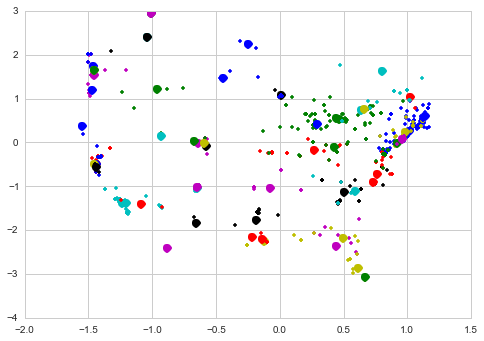

In [24]:
from itertools import cycle
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    pylab.plot(X[my_members, 0], X[my_members, 1], col + '.')
    pylab.plot(cluster_center[0], cluster_center[1], 'o', 
               markerfacecolor=col, markeredgecolor='k', markersize=9)


In [25]:
import scipy.cluster.hierarchy as sch

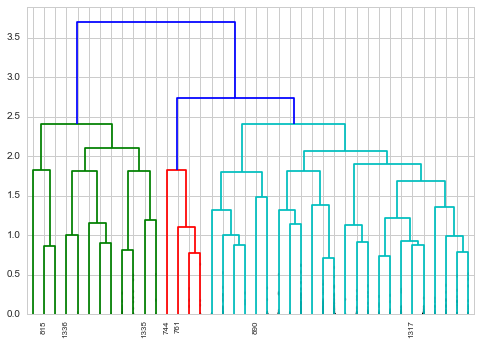

In [26]:
Y = sch.linkage(X, method='centroid')
D = sch.dendrogram(Y, truncate_mode='lastp', p=40, show_contracted=True,
                   show_leaf_counts=False, leaf_rotation=90., leaf_font_size=8.)

In [29]:
c = sch.fcluster(Y, 40, criterion='maxclust')
print np.unique(c)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


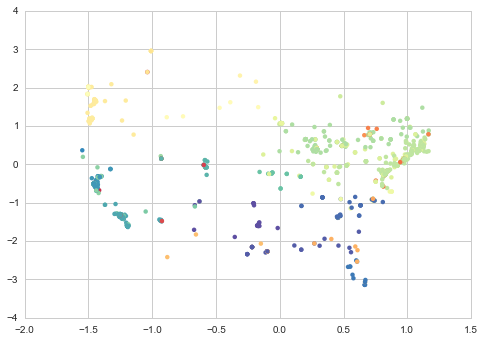

In [28]:
pylab.scatter(X[:,0], X[:,1], c=c, lw=0, cmap=pylab.cm.Spectral)

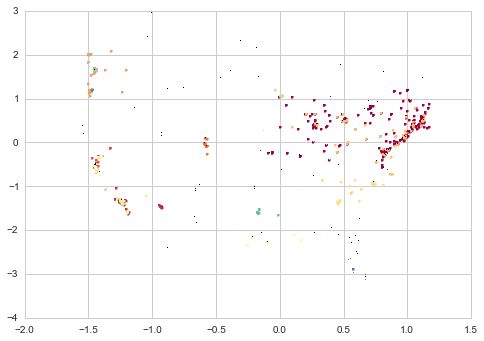

In [34]:
db = cluster.DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = pylab.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    pylab.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    pylab.plot(xy[:, 0], xy[:, 1], ',', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
